# ロジスティック回帰分析 - k分割交差検証

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数の関係をロジスティック回帰で分析し、10分割交差検証で評価します。

## 分析タスク

1. **タスク0: バグ発見の有無（二値分類）**: 各実行ごとにパラメータからバグ発見確率を予測
2. **タスク1: 5回実行して1回でもバグ発見（二値分類）**: パラメータから5回中1回でもバグ発見がある確率を予測
3. **タスク2: 5回実行して5回全てバグ発見（二値分類）**: パラメータから5回全てバグ発見になる確率を予測


In [1]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [2]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_bug_detection(logs_root='Logs'):
    """
    バグ発見の有無（二値分類）用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無を記録
    タスク0用
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            
            if not os.path.exists(detected_bugs_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    # バグ発見の有無を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    
                    if bug_row == ['timeout']:
                        # タイムアウトの場合はバグ発見なしとして扱う
                        bug_detected = 0
                    elif bug_row == ['null']:
                        # 正常終了の場合はバグ発見なし
                        bug_detected = 0
                    else:
                        # バグ発見
                        bug_detected = 1
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected  # バグ発見の有無（二値）
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    return df

def collect_data_for_tree_analysis(logs_root='Logs'):
    """
    タスク1、タスク2用のデータを収集
    パラメータごとに5回実行の結果を集計
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごと）
            bug_results = []
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row == ['timeout']:
                        bug_results.append('timeout')
                    elif bug_row == ['null']:
                        bug_results.append('normal')
                    else:
                        bug_results.append('bug')
            
            # 5回実行の結果を集計
            if len(bug_results) >= 5:
                # 最初の5回のみを使用
                first_5_results = bug_results[:5]
                
                # バグ発見の有無（1回でもバグ発見があれば1）
                bug_detected_any = 1 if 'bug' in first_5_results else 0
                
                # 5回全てバグ発見（5回全てbugなら1）
                bug_detected_all = 1 if all(r == 'bug' for r in first_5_results) else 0
                
                # データポイントを作成
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'bug_detected_any': bug_detected_any,  # 1回でもバグ発見
                    'bug_detected_all': bug_detected_all  # 5回全てバグ発見
                })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n1回でもバグ発見の分布:")
    print(df['bug_detected_any'].value_counts())
    print(f"\n5回全てバグ発見の分布:")
    print(df['bug_detected_all'].value_counts())
    return df


In [3]:
# k分割交差検証関数
def perform_cross_validation(
    model,
    X,
    y,
    model_name="",
    n_splits=10,
    random_state=42
):
    """
    k分割交差検証を実行し、結果を表示・可視化
    
    Args:
        model: 学習するモデル
        X: 特徴量データ
        y: 目的変数データ
        model_name: モデル名（表示用）
        n_splits: 分割数（デフォルト: 10）
        random_state: 乱数シード（デフォルト: 42）
    
    Returns:
        dict: 評価結果の辞書
    """
    print(f"\n{'='*70}")
    print(f"【{model_name}】{n_splits}分割交差検証結果")
    print(f"{'='*70}")
    
    # StratifiedKFoldを使用（クラス不均衡に対応）
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 複数の評価指標を取得
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }
    
    # 交差検証を実行
    cv_results = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    # 結果を整理
    results = {}
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    for metric in metrics:
        test_key = f'test_{metric}'
        train_key = f'train_{metric}'
        
        test_scores = cv_results[test_key]
        train_scores = cv_results[train_key] if train_key in cv_results else None
        
        results[metric] = {
            'test_mean': np.mean(test_scores),
            'test_std': np.std(test_scores),
            'test_min': np.min(test_scores),
            'test_max': np.max(test_scores),
            'test_scores': test_scores,
            'train_mean': np.mean(train_scores) if train_scores is not None else None,
            'train_std': np.std(train_scores) if train_scores is not None else None,
            'train_scores': train_scores
        }
    
    # 結果を表示
    print("\n【テストデータの評価指標（各foldの平均±標準偏差）】")
    result_df = pd.DataFrame({
        'Mean': [results[m]['test_mean'] for m in metrics],
        'Std': [results[m]['test_std'] for m in metrics],
        'Min': [results[m]['test_min'] for m in metrics],
        'Max': [results[m]['test_max'] for m in metrics]
    }, index=[m.capitalize() for m in metrics])
    print(result_df.round(4))
    
    if results['accuracy']['train_mean'] is not None:
        print("\n【訓練データの評価指標（各foldの平均±標準偏差）】")
        train_result_df = pd.DataFrame({
            'Mean': [results[m]['train_mean'] for m in metrics],
            'Std': [results[m]['train_std'] for m in metrics]
        }, index=[m.capitalize() for m in metrics])
        print(train_result_df.round(4))
    
    # 各foldのスコアを表示
    print(f"\n【各foldのテストスコア】")
    fold_scores_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'Accuracy': results['accuracy']['test_scores'],
        'Precision': results['precision']['test_scores'],
        'Recall': results['recall']['test_scores'],
        'F1-Score': results['f1']['test_scores']
    })
    print(fold_scores_df.round(4))
    
    # 可視化: 箱ひげ図
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # テストスコアの箱ひげ図
    test_data = [results[m]['test_scores'] for m in metrics]
    axes[0].boxplot(test_data, labels=[m.capitalize() for m in metrics])
    axes[0].set_title(f'Test Scores Distribution ({n_splits}-Fold CV)')
    axes[0].set_ylabel('Score')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])
    
    # 平均スコアと標準偏差のバープロット
    means = [results[m]['test_mean'] for m in metrics]
    stds = [results[m]['test_std'] for m in metrics]
    x_pos = np.arange(len(metrics))
    axes[1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([m.capitalize() for m in metrics])
    axes[1].set_title(f'Test Scores Mean ± Std ({n_splits}-Fold CV)')
    axes[1].set_ylabel('Score')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    return results


## タスク0: バグ発見の有無（二値分類）

各実行ごとにパラメータからバグ発見の有無を予測します。


In [4]:
# タスク0: バグ発見の有無（二値分類）のデータ収集
df_bug_detection = collect_data_for_bug_detection()

# 特徴量と目的変数の準備
X0 = df_bug_detection[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y0 = df_bug_detection['bug_detected']

print(f"\n特徴量の形状: {X0.shape}")
print(f"目的変数の形状: {y0.shape}")
print(f"\n目的変数の分布:")
print(y0.value_counts())


データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000
mean     500.000000    225.000000     50.000000      1.150000      0.576204
std      408.267192    234.016532     40.010185      0.572303      0.494182
min        0.000000      1.000000      1.000000      1.000000      0.000000
25%        0.000000     50.000000      1.000000      1.000000      0.000000
50%      500.000000    149.500000     50.000000      1.000000      1.000000
75%     1000.000000    300.000000     99.000000      1.000000      1.000000
max     1000.000000    700.000000     99.000000      4.000000      1.000000

バグ発見の有無の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64

特徴量の形状: (10800, 4)
目的変数の形状: (10800,)

目的変数の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64



【ロジスティック回帰（バグ発見の有無）】10分割交差検証結果

【テストデータの評価指標（各foldの平均±標準偏差）】
             Mean     Std     Min     Max
Accuracy   0.8036  0.0215  0.7704  0.8574
Precision  0.7932  0.0199  0.7583  0.8431
Recall     0.8922  0.0154  0.8732  0.9244
F1         0.8397  0.0169  0.8158  0.8819

【訓練データの評価指標（各foldの平均±標準偏差）】
             Mean     Std
Accuracy   0.8036  0.0018
Precision  0.7929  0.0034
Recall     0.8922  0.0031
F1         0.8396  0.0011

【各foldのテストスコア】
   Fold  Accuracy  Precision  Recall  F1-Score
0     1    0.7880     0.7839  0.8732    0.8261
1     2    0.8102     0.7960  0.9021    0.8457
2     3    0.7954     0.7880  0.8828    0.8327
3     4    0.8574     0.8431  0.9244    0.8819
4     5    0.8157     0.7992  0.9084    0.8503
5     6    0.8065     0.7929  0.8987    0.8425
6     7    0.7704     0.7583  0.8826    0.8158
7     8    0.8009     0.7937  0.8842    0.8365
8     9    0.7954     0.7836  0.8907    0.8337
9    10    0.7963     0.7930  0.8746    0.8318


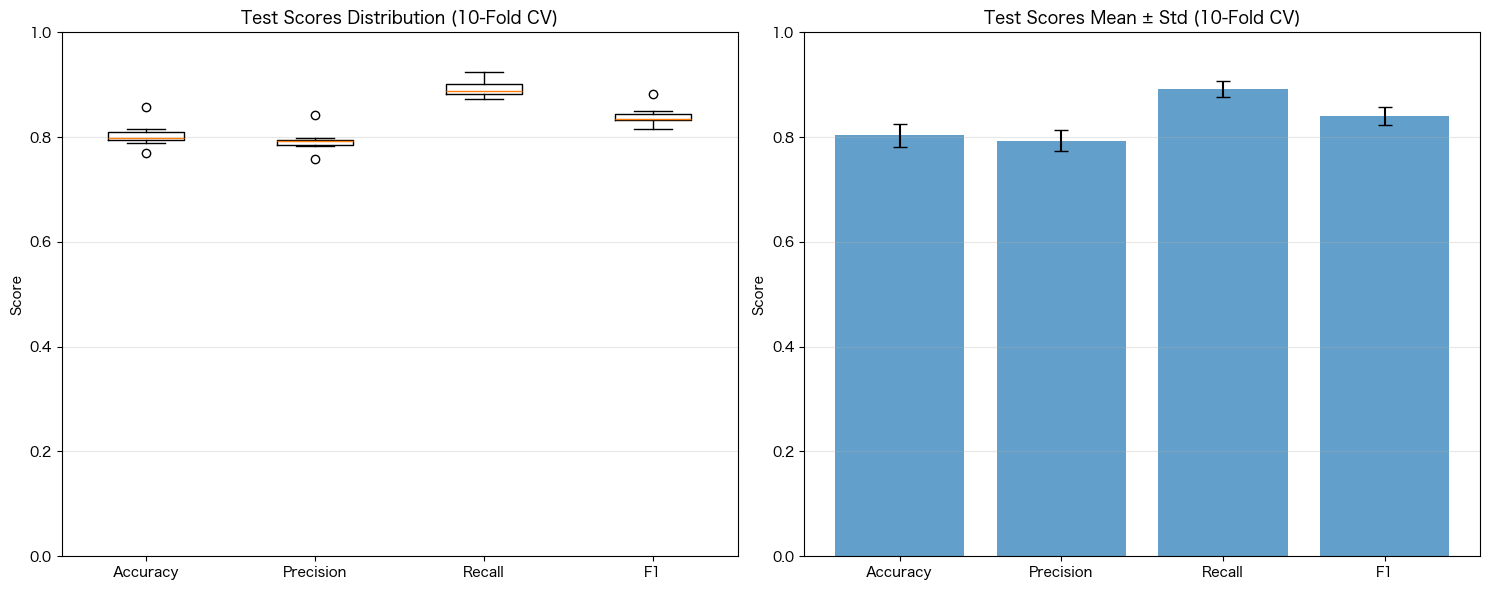

In [5]:
# タスク0: ロジスティック回帰の10分割交差検証
lr_model0 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

cv_results_lr0 = perform_cross_validation(
    lr_model0,
    X0,
    y0,
    model_name="ロジスティック回帰（バグ発見の有無）",
    n_splits=10,
    random_state=42
)


## タスク1: 5回実行して1回でもバグ発見（二値分類）

パラメータから5回中1回でもバグ発見がある確率を予測します。


In [6]:
# タスク1: 5回実行して1回でもバグ発見のデータ収集
df_tree = collect_data_for_tree_analysis()

# 特徴量と目的変数の準備
X1 = df_tree[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y1 = df_tree['bug_detected_any']

print(f"\n特徴量の形状: {X1.shape}")
print(f"目的変数の形状: {y1.shape}")
print(f"\n目的変数の分布:")
print(y1.value_counts())


データ収集完了: 2160件のレコード

データの基本統計:
              tree        cpNum  cpNum_range    cpNum_dir  bug_detected_any  \
count  2160.000000  2160.000000  2160.000000  2160.000000       2160.000000   
mean    500.000000   225.000000    50.000000     1.150000          0.844444   
std     408.342825   234.059885    40.017597     0.572409          0.362517   
min       0.000000     1.000000     1.000000     1.000000          0.000000   
25%       0.000000    50.000000     1.000000     1.000000          1.000000   
50%     500.000000   149.500000    50.000000     1.000000          1.000000   
75%    1000.000000   300.000000    99.000000     1.000000          1.000000   
max    1000.000000   700.000000    99.000000     4.000000          1.000000   

       bug_detected_all  
count       2160.000000  
mean           0.353241  
std            0.478087  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            1.000000  
max            1.000000  

1回でもバグ発見の分布:
bug_detec


【ロジスティック回帰（1回でもバグ発見）】10分割交差検証結果

【テストデータの評価指標（各foldの平均±標準偏差）】
             Mean     Std     Min     Max
Accuracy   0.7718  0.0238  0.7407  0.8241
Precision  0.9435  0.0085  0.9329  0.9589
Recall     0.7763  0.0307  0.7322  0.8462
F1         0.8514  0.0178  0.8272  0.8902

【訓練データの評価指標（各foldの平均±標準偏差）】
             Mean     Std
Accuracy   0.7747  0.0032
Precision  0.9456  0.0048
Recall     0.7780  0.0069
F1         0.8536  0.0027

【各foldのテストスコア】
   Fold  Accuracy  Precision  Recall  F1-Score
0     1    0.7824     0.9416  0.7923    0.8605
1     2    0.7963     0.9542  0.7978    0.8690
2     3    0.7731     0.9589  0.7650    0.8511
3     4    0.7407     0.9504  0.7322    0.8272
4     5    0.7639     0.9456  0.7637    0.8450
5     6    0.7454     0.9441  0.7418    0.8308
6     7    0.7546     0.9329  0.7637    0.8399
7     8    0.8241     0.9390  0.8462    0.8902
8     9    0.7593     0.9333  0.7692    0.8434
9    10    0.7778     0.9351  0.7912    0.8571


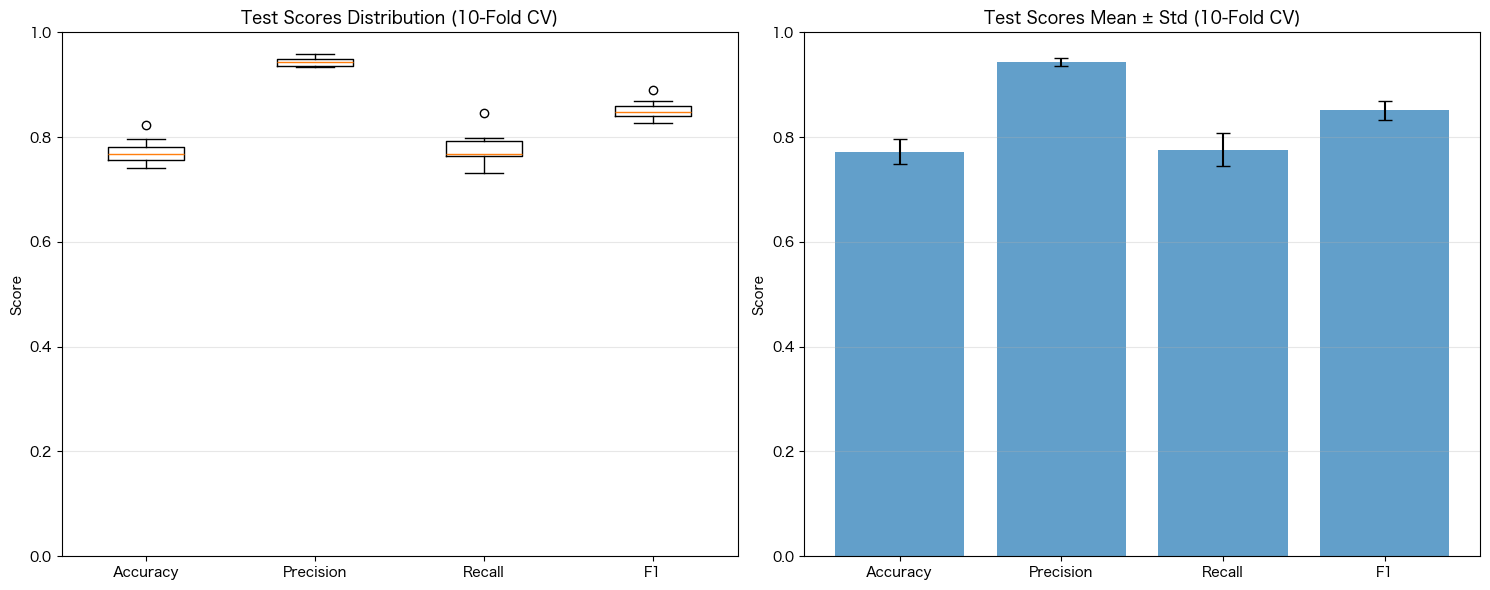

In [7]:
# タスク1: ロジスティック回帰の10分割交差検証
lr_model1 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced'
)

cv_results_lr1 = perform_cross_validation(
    lr_model1,
    X1,
    y1,
    model_name="ロジスティック回帰（1回でもバグ発見）",
    n_splits=10,
    random_state=42
)


## タスク2: 5回実行して5回全てバグ発見（二値分類）

パラメータから5回全てバグ発見になる確率を予測します。


In [8]:
# タスク2: 5回実行して5回全てバグ発見のデータ準備
# df_treeは既にタスク1で収集済み

# 特徴量と目的変数の準備
X2 = df_tree[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y2 = df_tree['bug_detected_all']

print(f"\n特徴量の形状: {X2.shape}")
print(f"目的変数の形状: {y2.shape}")
print(f"\n目的変数の分布:")
print(y2.value_counts())



特徴量の形状: (2160, 4)
目的変数の形状: (2160,)

目的変数の分布:
bug_detected_all
0    1397
1     763
Name: count, dtype: int64



【ロジスティック回帰（5回全てバグ発見）】10分割交差検証結果

【テストデータの評価指標（各foldの平均±標準偏差）】
             Mean     Std     Min     Max
Accuracy   0.7194  0.0315  0.6481  0.7500
Precision  0.6011  0.0474  0.5000  0.6567
Recall     0.6250  0.0540  0.5526  0.7237
F1         0.6113  0.0402  0.5250  0.6582

【訓練データの評価指標（各foldの平均±標準偏差）】
             Mean     Std
Accuracy   0.7192  0.0036
Precision  0.5981  0.0056
Recall     0.6255  0.0062
F1         0.6114  0.0045

【各foldのテストスコア】
   Fold  Accuracy  Precision  Recall  F1-Score
0     1    0.7500     0.6420  0.6753    0.6582
1     2    0.6898     0.5556  0.6494    0.5988
2     3    0.7407     0.6265  0.6753    0.6500
3     4    0.7454     0.6567  0.5789    0.6154
4     5    0.6991     0.5663  0.6184    0.5912
5     6    0.7454     0.6400  0.6316    0.6358
6     7    0.7407     0.6429  0.5921    0.6164
7     8    0.6481     0.5000  0.5526    0.5250
8     9    0.7037     0.5833  0.5526    0.5676
9    10    0.7315     0.5978  0.7237    0.6548


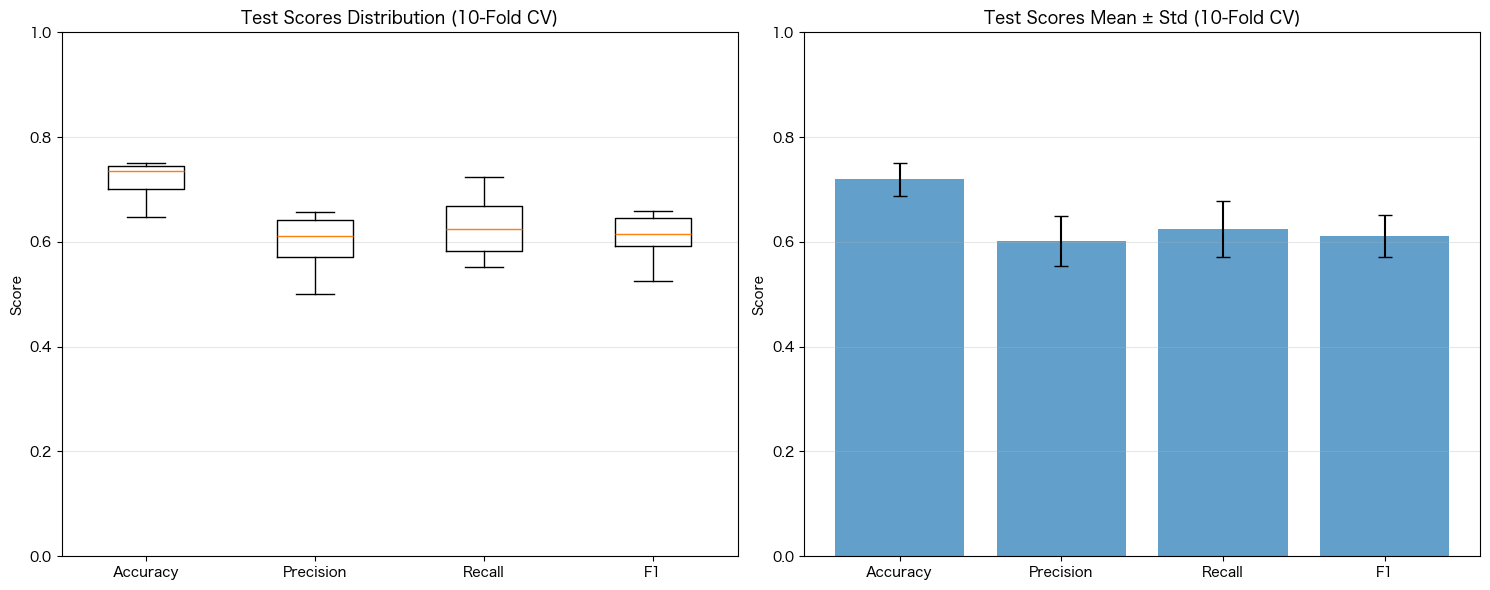

In [9]:
# タスク2: ロジスティック回帰の10分割交差検証
lr_model2 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

cv_results_lr2 = perform_cross_validation(
    lr_model2,
    X2,
    y2,
    model_name="ロジスティック回帰（5回全てバグ発見）",
    n_splits=10,
    random_state=42
)
